# 15. Model extensions

## Numerical experiments - Week 18/2025

_Boyan Mihaylov, MSc Computational Science (UVA/VU)_

Despite the moderate success of the analytical model in explaining the phase transition of the spore inoculum from a germinated to an ungerminated state when the critical threshold of $10^5$ spores/mL is crossed, a few issues remain to be addressed:

- It is known that spore cultures reach an asymptotic limit of their germination fraction, but the new analytical model has not yet been shown to represent that.
- The estimated effective permeation constant $P_{\textrm{eff}}$ is too low for any realistic barrier which does not interact with the inhibitor.
- The model cannot represent density-driven inhibition and exogenously driven exhibition in parallel.

The following model extensions are an attempt to address these issues.

## Prerequisite libraries

In [2]:
using PyPlot
using BlackBoxOptim
using Revise

Revise.includet("./conversions.jl")
Revise.includet("./diffusion.jl")
Revise.includet("./setup.jl")
Revise.includet("./plotting.jl")
Revise.includet("./analysis.jl")
Revise.includet("./utils.jl")
using .Conversions
using .Diffusion
using .Setup
using .Plotting
using .Analysis
using .Utils

## 1. Replicating Dantigny-like behaviour

### 1.1. Implementation of the Dantigny model

The model developed by Dantigny et al. [1] describes the germination percentage of a fungal culture through the formula

$$
\begin{equation}
p=p_{\textrm{max}}\left[1-\frac{1}{1+\left(\frac{t}{\tau_g}\right)^\nu}\right].
\end{equation}
$$

In it, $t$ is the time of evaluation of the probability, $p_{\textrm{max}}$ is a saturation limit of the germination fraction, $\tau_g$ is a characteristic germination time denoting the inflection point where $p=p_{\textrm{max}}/2$ and $\nu$ is a design parameter representing the heterogeneity of the culture.

It has been shown that the value of $p$ in this model saturates to $p_{\textrm{max}}$ in the long-time limits and has an asymmetrical sigmoid shape for $\nu>1$. As an illustration, some inferred parameters from Ijadpanahsaravi et al. [2] which describe the germination rate of _A. niger_ conidia in an alanine-rich environment, at a density of $1.333\times 10^5$ spores/mL, are $p_{\textrm{max}}=84.14$, $\tau_g=5.77$ and $\nu=3.36$. The code below illustrates the evolution of the germination percentage over the course of 50 hours.

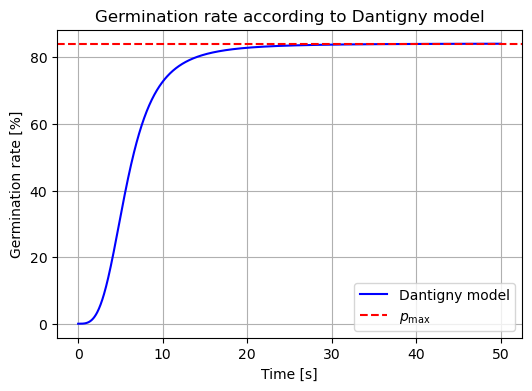

In [12]:
function dantigny(t, p_max, τ, ν)
    """
    Dantigny model for the germination of a fungal culture.
    inputs:
        t: time (in hours)
        p_max: maximum germination rate
        τ: time constant (in hours)
        ν: design parameter (dimensionless)
    outputs:
        p: germination rate (dimensionless)
    """
    p = p_max * (1 - 1 / (1 + (t / τ)^ν))
    return p
end

t_max = 50 # hours
p_max = 84.14
τ = 5.77
ν = 3.36

times = LinRange(0, t_max, 1000)
p_dantigny = dantigny.(times, p_max, τ, ν)

fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(times, p_dantigny, label="Dantigny model", color="blue")
ax.set_xlabel("Time [s]")
ax.set_ylabel("Germination rate [%]")
ax.grid()
ax.set_title("Germination rate according to Dantigny model")

ax.axhline(y=p_max, color="red", linestyle="--", label=L"p_{\text{max}}")
ax.legend()

gcf()

### 1.2. Time-dependent germination probability

Next, the time-dependent germination probability is simulated using the volume-based analytical model. Knowing that the germination response saturates at around 24 hours, the parameters of the model can be fitted again for the time-dependent comparison.

In [5]:
df_germination_rebuilt = parse_ijadpanahsaravi_data()

Row,CarbonSource,Density,Pmax,Pmax_CI_Lower,Pmax_CI_Upper,tau,tau_CI_Lower,tau_CI_Upper,d,d_CI_Lower,d_CI_Upper,N,M
,String3,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Int64,Int64
1,Ala,33333.3,95.98,92.44,99.51,6.93,6.59,7.26,3.83,3.16,4.5,373,10
2,Ala,66666.7,90.81,86.43,95.18,5.28,4.84,5.72,3.42,2.49,4.35,979,37
3,Ala,1.33333e5,84.14,78.58,89.69,5.77,5.17,6.37,3.36,2.24,4.48,1112,66
4,Ala,2.66667e5,71.91,61.67,82.14,6.31,5.06,7.57,2.55,1.31,3.79,1301,89
5,Arg,33333.3,25.06,-0.83,50.96,15.0,1.47,28.53,2.66,-0.16,5.48,626,94
6,Arg,66666.7,16.61,5.63,27.6,15.0,7.02,22.98,2.94,0.8,5.08,1026,19
7,Arg,1.33333e5,13.69,4.32,23.05,15.0,-0.44,30.44,1.41,0.67,2.15,1372,14
8,Arg,2.66667e5,11.25,-1.93,24.43,15.0,-12.95,42.95,1.32,0.16,2.48,1408,105
9,Pro,33333.3,94.95,91.22,98.69,4.55,4.19,4.91,3.7,2.69,4.71,526,7


5.9918304202075915e-6
Carbon source: Ala
Starting optimization with optimizer DiffEvoOpt{FitPopulation{Float64}, RadiusLimitedSelector, BlackBoxOptim.AdaptiveDiffEvoRandBin{3}, RandomBound{ContinuousRectSearchSpace}}
0.00 secs, 0 evals, 0 steps
0.50 secs, 6722 evals, 6627 steps, improv/step: 0.219 (last = 0.2188), fitness=0.001245841
1.00 secs, 13170 evals, 13078 steps, improv/step: 0.215 (last = 0.2119), fitness=0.001087512
1.51 secs, 18538 evals, 18451 steps, improv/step: 0.209 (last = 0.1937), fitness=0.001087466
2.01 secs, 23378 evals, 23294 steps, improv/step: 0.189 (last = 0.1115), fitness=0.001087466

Optimization stopped after 31108 steps and 2.50 seconds
Termination reason: Too many steps (101) without any function evaluations (probably search has converged)
Steps per second = 12448.18
Function evals per second = 11490.60
Improvements/step = 0.04602
Total function evaluations = 28715


Best candidate found: [3.87831, 3.77978e-5, 1.81853e-5]

Fitness: 0.001087466

Optimized par

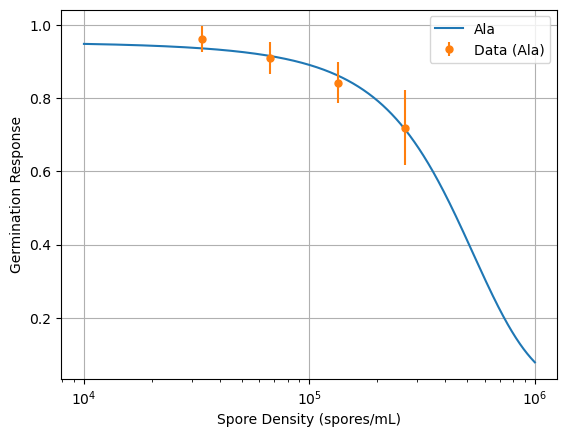

In [ ]:
# Constants
μ_ξ = 2.65
σ_ξ = 0.3
t_max = 24

# Bounds for the parameters
lower_bounds = [2, 1e-10, 1e-12]
upper_bounds = [5, 1.0, 0.1]
bounds = [(lb, ub) for (lb, ub) in zip(lower_bounds, upper_bounds)]

fig, ax = plt.subplots()

carbon_srcs = unique(df_germination_rebuilt[!, :CarbonSource])
sample_density_exp = LinRange(4, 6, 1000)

src = "Ala"

# Gather data
println("Carbon source: ", src)
df_src = filter(row -> row[:CarbonSource] == src, df_germination_rebuilt)
spore_densities = df_src[!, :Density]
spore_density_exponents = log10.(spore_densities)
germination_responses = df_src[!, :Pmax] * 0.01

# confidence_intervals
err_lo = df_src[!, :Pmax]-df_src[!, :Pmax_CI_Lower]
err_lo[err_lo .< 0] .= 0
err_hi = df_src[!, :Pmax_CI_Upper]-df_src[!, :Pmax]
err_lo = err_lo * 0.01
err_hi = err_hi * 0.01

# Define a scalar objective: sum of squared errors
function obj(params)
    ŷ = germination_response_simple.(10 .^ spore_density_exponents, 10 .^ (-params[1]), params[2], params[3], μ_ξ, σ_ξ, t_max * 3600)
    return sum(abs2, ŷ .- germination_responses)
end

# Fit model
res = bboptimize(params -> obj(params);
                SearchRange = bounds,
                NumDimensions = 3,
                MaxSteps = 100000)
p_opt = best_candidate(res)

Pₛ_fit = 10 .^ (-p_opt[1])
μ_γ_fit = p_opt[2]
σ_γ_fit = p_opt[3]

println("Optimized parameters:")
println("Pₛ: ", Pₛ_fit)
println("μ_γ: ", μ_γ_fit)
println("σ_γ: ", σ_γ_fit)
println("")

fit_responses = germination_response_simple.(10 .^ sample_density_exp, Pₛ_fit, μ_γ_fit, σ_γ_fit, μ_ξ, σ_ξ, t_max * 3600)
ax.plot(10 .^ sample_density_exp, fit_responses, label=src)
ax.errorbar(spore_densities, germination_responses, yerr=[err_lo, err_hi], fmt="o", markersize=5, label="Data ($(src))")

ax.set_xscale("log")
ax.set_xlabel("Spore Density (spores/mL)")
ax.set_ylabel("Germination Response")
ax.grid()
ax.legend()

gcf()

In [ ]:
# Sample evolution
ρ = 1.33333e5 # spores/mL

times = LinRange(0, t_max * 2, 1000) # hours

p_evolution = germination_response_simple.(ρ, Pₛ_fit, μ_γ_fit, σ_γ_fit, μ_ξ, σ_ξ, times .* 3600) .* 100 # Convert to percentage

1000-element Vector{Float64}:
  0.0
  1.0985270665090286e-17
  2.4363903125233555e-17
  4.065088540021347e-17
  6.047054348251181e-17
  8.457942459154397e-17
  1.1389389682129073e-16
  1.4952342148626472e-16
  1.9281064501352566e-16
  2.453796850335962e-16
  ⋮
 92.72379730617244
 92.72379983962915
 92.72380232035044
 92.72380474944079
 92.72380712798135
 92.72380945703047
 92.72381173762426
 92.72381397077696
 92.7238161574815

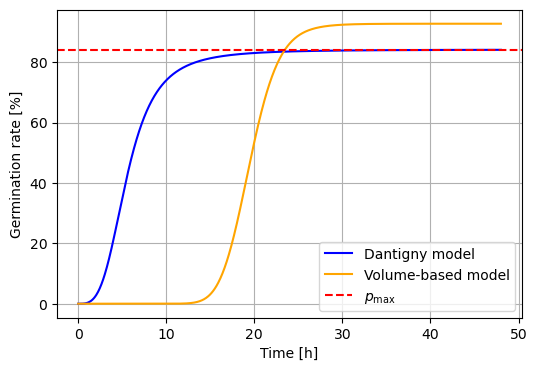

In [ ]:
fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(times, p_dantigny, label="Dantigny model", color="blue")
ax.plot(times, p_evolution, label="Volume-based model", color="orange")
ax.set_xlabel("Time [h]")
ax.set_ylabel("Germination rate [%]")
ax.grid()
# ax.set_title("Germination rate according to Dantigny model")

ax.axhline(y=p_max, color="red", linestyle="--", label=L"p_{\text{max}}")
ax.legend()

gcf()

Despite the common sigmoidal shape of the resulting evolutions, two major differences can be observed in the two models. First, the Dantigny saturates to levels lower than a full germination, while the volume-based model always saturates to 100%. Second, the peak of germination (concurrent with the steepest slope of the curve) may occur at a different time in the volume-based model, since the models rely on the attainment of a germination level at a specific time. This is also a consequence of the fact that the targeted germination level is not an asymptotic limit, but a momentary snapshot.

### 1.3. Fitting the equilibrium probability

Since the germination responses in this case are expressed as asymptotical limits of the Dantigny model [5], the volume-based model needs to be taken in its long-time equilibrium form,

$$
\begin{equation}
c_{\textrm{eq}}=\phi c_0.
\end{equation}
$$

The germination condition thus becomes

$$
\begin{equation}
c_{\textrm{eq}} < c_T,
\end{equation}
$$

or, using the previously defined random variables,

$$
\begin{equation}
\phi{(\xi, \rho_s)} c_0 < \gamma c_0,
\end{equation}
$$

$$
\begin{equation}
\phi{(\xi, \rho_s)} < \gamma.
\end{equation}
$$

The probability for germination under a certain spore density is then expressed as

$$
\begin{equation}
p{(\rho_s)}=P{(\phi < \gamma\ |\ \xi)}=\int_0^\infty{P{(\phi < \gamma\ |\ \xi, \rho_s)}\ f_\xi\ d{\xi}}.
\end{equation}
$$

Following the Gaussian assumption about $\xi$,

$$
\begin{equation}
p{(\rho_s)}=\int_0^\infty{\left[1-\Phi{\left(\frac{\phi{(\xi)}-\mu_\gamma}{\sigma_\gamma}\right)}\right]\ \frac{1}{\sqrt{2\pi}\sigma_\xi}\exp{\left(-\frac{(\xi-\mu_\xi)^2}{2\sigma_\xi^2}\right)}\ d{\xi}}.
\end{equation}
$$

This expression accounts for the threshold distribution ($\mu_\gamma$, $\sigma_\gamma$), but there permeation constant is omitted as a parameter, since the time component is missing in the equilibrium formulation. One can reintroduce it by taking the half-saturation time $\tau_g$ from the Dantigny model as an additional input variable and observing that, at this time, the germination probability is half of the maximum $P_{\textrm{max}}$:

$$
\begin{equation}
\int_0^\infty{\left[1-\Phi{\left(\frac{\beta{(\xi, P_s, \rho_s, \tau_g)}-\mu_\gamma}{\sigma_\gamma}\right)}\right]\ \frac{1}{\sqrt{2\pi}\sigma_\xi}\exp{\left(-\frac{(\xi-\mu_\xi)^2}{2\sigma_\xi^2}\right)}\ d{\xi}}=\frac{1}{2}P_{\textrm{max}}.
\end{equation}
$$

Thus, using both of these constraints enables an optimisation of the model parameters towards alignment of both the time-dependent and the equilibrium state of the model with the experimental data.

Carbon source: Ala
Starting optimization with optimizer DiffEvoOpt{FitPopulation{Float64}, RadiusLimitedSelector, BlackBoxOptim.AdaptiveDiffEvoRandBin{3}, RandomBound{ContinuousRectSearchSpace}}
0.00 secs, 0 evals, 0 steps
0.50 secs, 1353 evals, 1248 steps, improv/step: 0.276 (last = 0.2756), fitness=0.193081338
1.01 secs, 2572 evals, 2467 steps, improv/step: 0.240 (last = 0.2026), fitness=0.191544547
1.51 secs, 4113 evals, 4009 steps, improv/step: 0.238 (last = 0.2367), fitness=0.191527375
2.01 secs, 5670 evals, 5568 steps, improv/step: 0.232 (last = 0.2149), fitness=0.191527362
2.51 secs, 7211 evals, 7109 steps, improv/step: 0.224 (last = 0.1973), fitness=0.191527362
3.01 secs, 8624 evals, 8524 steps, improv/step: 0.226 (last = 0.2332), fitness=0.191527362

Optimization stopped after 10001 steps and 3.48 seconds
Termination reason: Max number of steps (10000) reached
Steps per second = 2872.20
Function evals per second = 2900.63
Improvements/step = 0.22450
Total function evaluations 

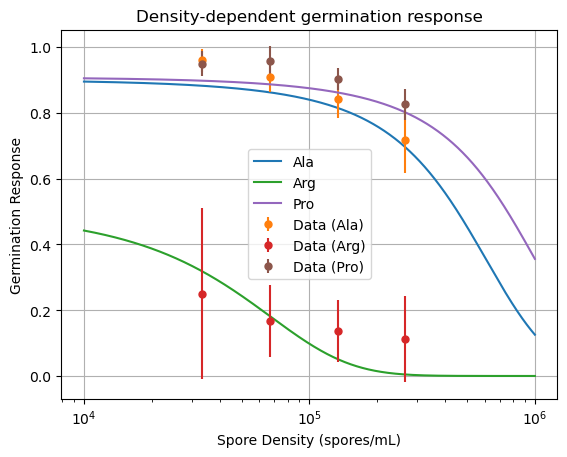

In [6]:
# Constants
μ_ξ = 2.65
σ_ξ = 0.3

# Bounds for the parameters
# lower_bounds = [2, 1e-10, 1e-12]
# upper_bounds = [9, 1.0, 0.1]
lower_bounds = [3, 1e-20, 1e-12]
upper_bounds = [4, 1e-4, 1e-4]
bounds = [(lb, ub) for (lb, ub) in zip(lower_bounds, upper_bounds)]

fig, ax = plt.subplots()

carbon_srcs = unique(df_germination_rebuilt[!, :CarbonSource])
p_opt = zeros(length(carbon_srcs), 3)
spore_densities_all = []
half_saturation_times_all = []
design_parameters_all = []
germination_responses_all = []

sample_density_exp = LinRange(4, 6, 1000)
sample_time = 24 * 3600 # 24 hours in seconds

for (i, src) in enumerate(carbon_srcs)

    # Gather data
    println("Carbon source: ", src)
    df_src = filter(row -> row[:CarbonSource] == src, df_germination_rebuilt)
    spore_densities = df_src[!, :Density]
    spore_density_exponents = log10.(spore_densities)
    half_saturation_times = df_src[!, :tau] * 3600 # Convert to seconds
    germination_responses = df_src[!, :Pmax] * 0.01
    design_parameter = df_src[!, :d]

    inputs = collect(zip(spore_density_exponents, half_saturation_times))

    # confidence_intervals
    err_lo = df_src[!, :Pmax]-df_src[!, :Pmax_CI_Lower]
    err_lo[err_lo .< 0] .= 0
    err_hi = df_src[!, :Pmax_CI_Upper]-df_src[!, :Pmax]
    err_lo = err_lo * 0.01
    err_hi = err_hi * 0.01

    push!(spore_densities_all, spore_densities)
    push!(half_saturation_times_all, half_saturation_times)
    push!(design_parameters_all, design_parameter)
    push!(germination_responses_all, germination_responses)

    # Define a scalar objective: sum of squared errors
    function obj(params)
        ŷ₁ = germination_response_simple.(10 .^ spore_density_exponents, 10 ^ (-params[1]), params[2], params[3], μ_ξ, σ_ξ, half_saturation_times)
        ŷ₂ = germination_response_equilibrium.(10 .^ spore_density_exponents, params[2], params[3], μ_ξ, σ_ξ)
        ŷ₃ = germination_response_simple.(10 .^ spore_density_exponents, 10 ^ (-params[1]), params[2], params[3], μ_ξ, σ_ξ, half_saturation_times .* 5)
        return sum(abs2, ŷ₁ .- (0.5 .* germination_responses)) + sum(abs2, ŷ₂ .- germination_responses) + sum(abs2, ŷ₃ .- germination_responses) # half saturation + equilibrium + full saturation
    end

    # Fit model
    res = bboptimize(params -> obj(params);
                 SearchRange = bounds,
                 NumDimensions = 3,
                 MaxSteps = 10000)
    p_opt[i, :] = best_candidate(res)

    Pₛ_fit = 10 .^ (-p_opt[i, 1])
    μ_γ_fit = p_opt[i, 2]
    σ_γ_fit = p_opt[i, 3]

    println("Optimized parameters:")
    println("Pₛ: ", Pₛ_fit)
    println("μ_γ: ", μ_γ_fit)
    println("σ_γ: ", σ_γ_fit)
    println("")
    
    fit_responses = [germination_response_simple(10 .^ exponent, Pₛ_fit, μ_γ_fit, σ_γ_fit, μ_ξ, σ_ξ, sample_time) for exponent in sample_density_exp]
    ax.plot(10 .^ sample_density_exp, fit_responses, label=src)
    ax.errorbar(spore_densities, germination_responses, yerr=[err_lo, err_hi], fmt="o", markersize=5, label="Data ($(src))")
end

ax.set_xscale("log")
ax.set_xlabel("Spore Density (spores/mL)")
ax.set_ylabel("Germination Response")
ax.set_title("Density-dependent germination response")
ax.grid()
ax.legend()

gcf()

An exemplary time-evolution of the germination percentage is plotted below for the alanine-medium at the highest experimental spore density.

Carbon source: Ala
Spore density: 266666.6666666667
Half-saturation time: 22716.0
Design parameter: 2.55
Permeation constant: 0.00044045878777218344
μ_γ: 3.655724464324575e-5
σ_γ: 2.8479093312179536e-5


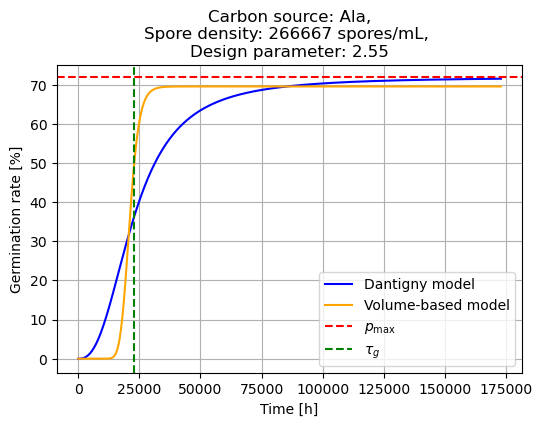

In [13]:
# Sample evolution
medium_index = 1
density_index = 4
ρ = spore_densities_all[medium_index][density_index] # spores/mL
τ = half_saturation_times_all[medium_index][density_index] # seconds
ν = design_parameters_all[medium_index][density_index] # dimensionless
p_max = germination_responses_all[medium_index][density_index] * 100 # Convert to percentage

println("Carbon source: ", carbon_srcs[medium_index])
println("Spore density: ", ρ)
println("Half-saturation time: ", τ)
println("Design parameter: ", ν)
println("Permeation constant: ", 10^(-p_opt[medium_index, 1]))
println("μ_γ: ", p_opt[medium_index, 2])
println("σ_γ: ", p_opt[medium_index, 3])

times = LinRange(0, sample_time * 2, 1000) # hours

p_evolution = germination_response_simple.(ρ, 10^(-p_opt[medium_index, 1]), p_opt[medium_index, 2], p_opt[medium_index, 3], μ_ξ, σ_ξ, times) .* 100 # Convert to percentage
# p_evolution = germination_response_simple.(ρ, Pₛ_fit*0.0025, p_opt[medium_index, 2], p_opt[medium_index, 3], μ_ξ, σ_ξ, times) .* 100 # Convert to percentage
p_dantigny = dantigny.(times, p_max, τ, ν)

# Plot
fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(times, p_dantigny, label="Dantigny model", color="blue")
ax.plot(times, p_evolution, label="Volume-based model", color="orange")
ax.set_xlabel("Time [h]")
ax.set_ylabel("Germination rate [%]")
ax.grid()
# ax.set_title("Germination rate according to Dantigny model")

ax.axhline(y=p_max, color="red", linestyle="--", label=L"p_{\text{max}}")
ax.axvline(x=τ, color="green", linestyle="--", label=L"\tau_g")
# ax.axvline(x=sample_time, color="gray", linestyle="--", label="Sample time")
ax.legend()
ax.set_title("Carbon source: $(carbon_srcs[medium_index]),\nSpore density: $(round(Int, ρ)) spores/mL, \nDesign parameter: $ν")

gcf()

Despite the appropriate fit of the half-saturation level and the asymptotic germination limit, the volume-based model produces a much steeper onset of germination compared to the Dantigny model. Since the design parameter in the latter controls the steepness of this onset, the plot below illustrates how a modification of $\nu$ can yield a closer correspondence:

Carbon source: Ala
Spore density: 266666.6666666667
Half-saturation time: 22716.0
Design parameter: 7.6499999999999995
Permeation constant: 0.0004404587862779769
μ_γ: 3.655724493091372e-5
σ_γ: 2.847909350900755e-5


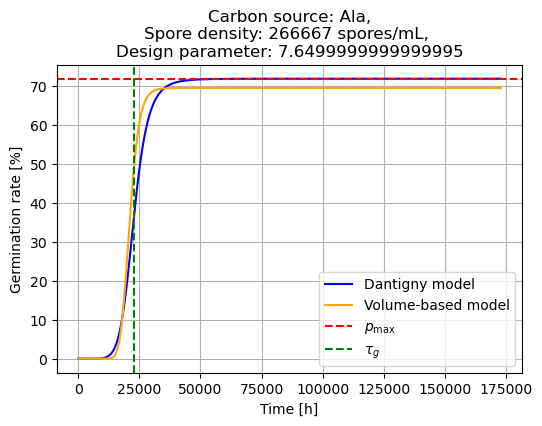

In [197]:
# Sample evolution
medium_index = 1
density_index = 4
ρ = spore_densities_all[medium_index][density_index] # spores/mL
τ = half_saturation_times_all[medium_index][density_index] # seconds
ν = design_parameters_all[medium_index][density_index]*3.0 # dimensionless
p_max = germination_responses_all[medium_index][density_index] * 100 # Convert to percentage

println("Carbon source: ", carbon_srcs[medium_index])
println("Spore density: ", ρ)
println("Half-saturation time: ", τ)
println("Design parameter: ", ν)
println("Permeation constant: ", 10^(-p_opt[medium_index, 1]))
println("μ_γ: ", p_opt[medium_index, 2])
println("σ_γ: ", p_opt[medium_index, 3])

times = LinRange(0, sample_time * 2, 1000) # hours

p_evolution = germination_response_simple.(ρ, 10^(-p_opt[medium_index, 1]), p_opt[medium_index, 2], p_opt[medium_index, 3], μ_ξ, σ_ξ, times) .* 100 # Convert to percentage
p_dantigny = dantigny.(times, p_max, τ, ν)

# Plot
fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(times, p_dantigny, label="Dantigny model", color="blue")
ax.plot(times, p_evolution, label="Volume-based model", color="orange")
ax.set_xlabel("Time [h]")
ax.set_ylabel("Germination rate [%]")
ax.grid()

ax.axhline(y=p_max, color="red", linestyle="--", label=L"p_{\text{max}}")
ax.axvline(x=τ, color="green", linestyle="--", label=L"\tau_g")
ax.legend()
ax.set_title("Carbon source: $(carbon_srcs[medium_index]),\nSpore density: $(round(Int, ρ)) spores/mL, \nDesign parameter: $ν")

gcf()

This scenario may still be representative of the experimental data, since the modified value of $\nu$ is close to the upper limit of its confidence interval.

In [16]:
p_opt

3×3 Matrix{Float64}:
 3.35609  3.65572e-5   2.84791e-5
 3.70085  1.03301e-20  5.68395e-6
 3.19635  6.07702e-5   4.57027e-5

## 2. Cell wall adsorption model

If the inhibitor molecules strongly interact with the cell wall, e.g. with the hydrophobin or polysaccharide networks, their effective permeation incorporates the release deceleration due to temporary retainment in an adsorption matrix. The adsorption process can be described as a reaction between an inhibitor $\textrm{I}$ and a binding site $\textrm{S}$ to a bound complex $\textrm{IS}$:

$$
\begin{equation}
    \textrm{I}\ +\ \textrm{S}\ \leftrightarrows\ \textrm{IS}.
\end{equation}
$$

The reaction kinetics are governed by the reaction constants $k_{\textrm{on}}$ and $k_{\textrm{off}}$. Separating the concentration of inhibitor in the cell wall into a concentration of bound and of unbound inhibitor ($q$ and $c_{\textrm{free}}$, respectively), the concentration of available (unbound) sites is $B_\textrm{max}-q$, where $B_\textrm{max}$ is the maximum binding capacity in mol of binding sites per unit volume. The rate equation for $q$ is then

$$
\begin{equation}
    \frac{\partial{q}}{\partial{t}}=k_{\textrm{on}}\, c_{\textrm{free}}\, (B_\textrm{max}-q)-k_{\textrm{off}}\, q.
\end{equation}
$$

Assuming that the binding and unbinding equilibrate quickly compared to the cell wall permeation, the steady-state ($\frac{\partial{q}}{\partial{t}}\approx 0$) is given by

$$
\begin{equation}
    k_{\textrm{on}}\, c_{\textrm{free}}\, (B_\textrm{max}-q_{\textrm{eq}})=k_{\textrm{off}}\, q_{\textrm{eq}}.
\end{equation}
$$

The solution for this equation is the Langmuir isotherm

$$
\begin{equation}
    q_{\textrm{eq}}=\frac{B_\textrm{max}\,K_{\textrm{eq}}\,c_{\textrm{free}}}{1+K_{\textrm{eq}}\,c_{\textrm{free}}},
\end{equation}
$$

where $K_{\textrm{eq}}=\frac{k_{\textrm{on}}}{k_{\textrm{off}}}$ is an equilibrium constant. As long as $K_{\textrm{eq}}\,c_{\textrm{free}}\ll 1$, i.e. the binding affinity is not strong enough to cause saturation of bound sites, the linear approximation

$$
\begin{equation}
    q_{\textrm{eq}}\approx B_\textrm{max}\,K_{\textrm{eq}}\,c_{\textrm{free}}
\end{equation}
$$

can be made. Thus, following the mass conservation law, the inhibitor diffusion in the cell wall follows the dynamics

$$
\begin{equation}
    \frac{\partial{c_{\textrm{cw}}}}{\partial{t}}= \frac{\partial}{\partial{t}}(q+c_{\textrm{free}})=D\frac{\partial^2{c_{\textrm{free}}}}{\partial{t}^2},
\end{equation}
$$

where only $c_{\textrm{free}}$ diffuses freely according to Fick's law. Thus,

$$
\begin{equation}
    (1+B_\textrm{max}\,K_{\textrm{eq}})\,\frac{\partial{c_{\textrm{free}}}}{\partial{t}}=D\frac{\partial^2{c_{\textrm{free}}}}{\partial{t}^2},
\end{equation}
$$

$$
\begin{equation}
    \frac{\partial{c_{\textrm{free}}}}{\partial{t}}=\frac{D}{1+B_\textrm{max}\,K_{\textrm{eq}}}\,\frac{\partial^2{c_{\textrm{free}}}}{\partial{t}^2}.
\end{equation}
$$

It becomes evident that the diffusion constant is replaced by an effective diffusivity modulated by adsorption:

$$
\begin{equation}
    D_{\textrm{ad}}=\frac{D}{1+B_\textrm{max}\,K_{\textrm{eq}}}.
\end{equation}
$$

In the general permeation case, this can be translated to an effective permeation constant:

$$
\begin{equation}
    P_{\textrm{ad}}=\frac{D_{\textrm{ad}}}{d}=\frac{1}{d}\frac{D}{1+K_{\textrm{eq}}\,B_{\textrm{max}}},
\end{equation}
$$

$$
\begin{equation}
    P_{\textrm{ad}}=\frac{P_{\textrm{eff}}}{1+K_{\textrm{eq}}\,B_{\textrm{max}}}.
\end{equation}
$$

Also, using the Meyer-Overton rule,

$$
\begin{equation}
    P_{\textrm{ad}}=\frac{KD_{\textrm{ad}}}{d}=\frac{K}{d}\frac{D}{1+K_{\textrm{eq}}\,B_{\textrm{max}}},
\end{equation}
$$

$$
\begin{equation}
    P_{\textrm{ad}}=\frac{P_s}{1+K_{\textrm{eq}}\,B_{\textrm{max}}}.
\end{equation}
$$

Conversely, knowing the material-specific permeation constant of the cell wall, $P_s$ or $P_{\textrm{eff}}$, it is possible to compute the product of the adsorption parameters from the fitted permeation constant as

$$
\begin{equation}
    K_{\textrm{eq}}\,B_{\textrm{max}}=\frac{P_{\textrm{eff}}}{P_{\textrm{ad}}}-1.
\end{equation}
$$

For instance, taking the estimate for a full cell wall composition with a less permeable polysaccharide matrix, $P_{\textrm{eff}}=2.474\times10^{-5}\ \textrm{cm/s}$, and the fitted permeation constant for an alanine-rich medium, one can compute the following:

<!-- This justifies the use of a wider range of material-characteristic permeation constants while quantifying the potential adsorption dynamics in the cell wall. It can thus be tested if, given a specific permeation value (e.g. the lowest permeation coefficient from Notebook 12), the experimental data can be approximated without violating the assumption of a linear regime ($K_{\textrm{eq}}\,c_{\textrm{free}}\ll 1$). -->

In [184]:
P_eff = cm_to_um(2.474e-5)
P_fit = 10^(-p_opt[1, 1])
K_eq_B_max = P_eff / P_fit - 1

560.6870581110022

The assumption of a linear regime imposes that $K_{\textrm{eq}}\,c_{\textrm{free}}\ll 1$. Thus, considering that the maximum concentration in the spore is $c_0=1.5\times10^{-5}\ \textrm{M}$, and that $K_{\textrm{eq}}\,c_0\le 0.1$, the resulting upper limit for the equilibrium constant is $K_{\textrm{eq}}=6.67\times 10^3\ \textrm{M}^{-1}$. Consequently, the binding capacity is $B_{\textrm{max}}=0.084\ \textrm{M}$, as calculated below.

In [185]:
B_max = K_eq_B_max/6.67e3

0.08406102820254906

This indicates a high binding affinity of the inhibitor, but also a relatively large abundance of binding sites for the concentration of inhibitor provided. The estimates for $K_{\textrm{eq}}$ and $B_{\textrm{max}}$ are consistent with findings in literature [3, 4].

## 3. Inducer-inhibitor interaction

As conidial germination is influenced not only by auto-inhibition but also by inducing carbon signals in the medium, the question arises how these two mechanisms interact to enable the break of dormancy.

### 3.1. Independent induction and inhibition

In the simplest scenario, the two mechanisms can be viewed as mutually independent, causing germination when both conditions,

$$
\begin{equation}
c_{\textrm{in}}<c_T\quad\textrm{and}\quad sc_{\textrm{cs}}>s_T,
\end{equation}
$$

are fulfilled simultaneously. Here, $c_{\textrm{in}}$ is the residual inhibitor concentration in the spore, $c_{\textrm{cs}}$ is the carbon source concentration around the carbon sensing proteins, $s$ quantifies the inducing strength of the carbon source and $c_T$ and $s_T$ are the thresholds for the inhibitory and the inducing signals, respectively.

Similar to the inhibition threshold, the induction threshold $s_T$ can be modelled by a normally distributed random variable $\omega$, with mean $\mu_\omega$ and standard deviation $\sigma_\omega$. Furthermore, since the concentrations of inducer do not vary in the experiments of interest, $c_{\textrm{cs}}$ can be absorbed into the signal strength $s$. The germination probability can therefore be expressed as

$$
\begin{equation}
p=P{\left(\beta<\gamma\ \cap\ \omega < s\right)}=P{(\beta<\gamma)}\cdot P{(\omega < s)}.
\end{equation}
$$

The first probability follows the familiar formula

$$
\begin{equation}
P{(\beta<\gamma)}=\int_0^\infty{\left[1-\Phi{\left(\frac{\beta{(\xi)}-\mu_\gamma}{\sigma_\gamma}\right)}\right]\ \frac{1}{\sqrt{2\pi}\sigma_\xi}\exp{\left(-\frac{(\xi-\mu_\xi)^2}{2\sigma_\xi^2}\right)}\ d{\xi}}.
\end{equation}
$$

The second probability simply incorporates a Gaussian CDF:

$$
\begin{equation}
P{(\omega < s)}=\Phi{\left(\frac{s-\mu_\omega}{\sigma_\omega}\right)}.
\end{equation}
$$

Hence,

$$
\begin{equation}
P{\left(\beta<\gamma\ \cap\ \omega < s\right)}=\Phi{\left(\frac{s-\mu_\omega}{\sigma_\omega}\right)}\int_0^\infty{\left[1-\Phi{\left(\frac{\beta{(\xi)}-\mu_\gamma}{\sigma_\gamma}\right)}\right]\ \frac{1}{\sqrt{2\pi}\sigma_\xi}\exp{\left(-\frac{(\xi-\mu_\xi)^2}{2\sigma_\xi^2}\right)}\ d{\xi}}.
\end{equation}
$$

This expression introduces three new unknown variables: $s$, $\mu_\omega$ and $\sigma_\omega$. It is assumed that the inducer threshold is universal for all types of carbon sources, but the induction index $s$ describes the specific signalling efficacy of different nutrients. Therefore, it is interesting to investigate whether fitting the model over experimental data produces consistent values for $\mu_\omega$ and $\sigma_\omega$, with varying $s$ for different carbon sources.

It is important to note that only $s$ varies across different inducing media, while the rest of the parameters apply to all cases. Therefore, the optimisation must simultaneously reduce the error in the general data set and its constituent data sets by using the respective parameters.

<!-- The documented concentration of the inducers is $c_{\textrm{cs}}=0.01\ \textrm{M}$ [2].  -->

For now, it is assumed that the inducers easily permeate the rodlet layer and their concentration quickly equilibrates around the receptor proteins.

In [ ]:
# Constants
μ_ξ = 2.65
σ_ξ = 0.3

# Bounds for the parameters
# lower_bounds = [2, 1e-10, 1e-12]
# upper_bounds = [9, 1.0, 0.1]
lower_bounds = [3, 1e-5, 1e-5]
upper_bounds = [4, 1e-4, 1e-4]
bounds = [(lb, ub) for (lb, ub) in zip(lower_bounds, upper_bounds)]

fig, ax = plt.subplots()

carbon_srcs = unique(df_germination_rebuilt[!, :CarbonSource])
p_opt = zeros(length(carbon_srcs), 3)
spore_densities_all = []
half_saturation_times_all = []
design_parameters_all = []
germination_responses_all = []

sample_density_exp = LinRange(4, 6, 1000)
sample_time = 24 * 3600 # 24 hours in seconds

for (i, src) in enumerate(carbon_srcs)

    # Gather data
    println("Carbon source: ", src)
    df_src = filter(row -> row[:CarbonSource] == src, df_germination_rebuilt)
    spore_densities = df_src[!, :Density]
    spore_density_exponents = log10.(spore_densities)
    half_saturation_times = df_src[!, :tau] * 3600 # Convert to seconds
    germination_responses = df_src[!, :Pmax] * 0.01
    design_parameter = df_src[!, :d]

    inputs = collect(zip(spore_density_exponents, half_saturation_times))

    # confidence_intervals
    err_lo = df_src[!, :Pmax]-df_src[!, :Pmax_CI_Lower]
    err_lo[err_lo .< 0] .= 0
    err_hi = df_src[!, :Pmax_CI_Upper]-df_src[!, :Pmax]
    err_lo = err_lo * 0.01
    err_hi = err_hi * 0.01

    push!(spore_densities_all, spore_densities)
    push!(half_saturation_times_all, half_saturation_times)
    push!(design_parameters_all, design_parameter)
    push!(germination_responses_all, germination_responses)

    # Define a scalar objective: sum of squared errors
    function obj(params)
        ŷ₁ = germination_response_simple.(10 .^ spore_density_exponents, 10 ^ (-params[1]), params[2], params[3], μ_ξ, σ_ξ, half_saturation_times)
        ŷ₂ = germination_response_equilibrium.(10 .^ spore_density_exponents, params[2], params[3], μ_ξ, σ_ξ)
        ŷ₃ = germination_response_simple.(10 .^ spore_density_exponents, 10 ^ (-params[1]), params[2], params[3], μ_ξ, σ_ξ, half_saturation_times .* 5)
        return sum(abs2, ŷ₁ .- (0.5 .* germination_responses)) + sum(abs2, ŷ₂ .- germination_responses) + sum(abs2, ŷ₃ .- germination_responses) # half saturation + equilibrium + full saturation
    end

    # Fit model
    res = bboptimize(params -> obj(params);
                 SearchRange = bounds,
                 NumDimensions = 3,
                 MaxSteps = 10000)
    p_opt[i, :] = best_candidate(res)

    Pₛ_fit = 10 .^ (-p_opt[i, 1])
    μ_γ_fit = p_opt[i, 2]
    σ_γ_fit = p_opt[i, 3]

    println("Optimized parameters:")
    println("Pₛ: ", Pₛ_fit)
    println("μ_γ: ", μ_γ_fit)
    println("σ_γ: ", σ_γ_fit)
    println("")
    
    fit_responses = [germination_response_simple(10 .^ exponent, Pₛ_fit, μ_γ_fit, σ_γ_fit, μ_ξ, σ_ξ, sample_time) for exponent in sample_density_exp]
    ax.plot(10 .^ sample_density_exp, fit_responses, label=src)
    ax.errorbar(spore_densities, germination_responses, yerr=[err_lo, err_hi], fmt="o", markersize=5, label="Data ($(src))")
end

ax.set_xscale("log")
ax.set_xlabel("Spore Density (spores/mL)")
ax.set_ylabel("Germination Response")
ax.grid()
ax.legend()

gcf()

### 3.2. Inducer-modulated inhibition threshold

A second possibility is that the carbon signals, as a consequence of the cAMP-PKA pathway, trigger a lifting of the inhibition threshold, making a break of dormancy mediated by inhibitor depletion easier to reach.

Previously, it was observed that the variation in germination response under varying inducing media is explainable by a modulation of the inhibitor concentration threshold and not so much by a change in permeability.

Thus, the condition for germination would be

$$
\begin{equation}
c_{\textrm{in}}<c_T,
\end{equation}
$$

or, as previously defined,

$$
\beta<\gamma.
$$

This time, however, the depletion threshold is a function of the inducer strength $s$. To account for individual variations in signal susceptibility, $s$ can also be modelled as a normally distributed random variable and effectively be identified with $\gamma$. The germination probability is then still expressed by the familiar formula,

$$
\begin{equation}
P{(\beta{(\xi)}<\gamma)}=\int_0^\infty{\left[1-\Phi{\left(\frac{\beta{(\xi)}-\mu_\gamma}{\sigma_\gamma}\right)}\right]\ \frac{1}{\sqrt{2\pi}\sigma_\xi}\exp{\left(-\frac{(\xi-\mu_\xi)^2}{2\sigma_\xi^2}\right)}\ d{\xi}},
\end{equation}
$$

but this time $\gamma$ is explicitly defined as the inducing strength.

### 3.3. Inhibitor-modulated carbon sensitivity

Another possibility is that the inhibitor suppresses the carbon signalling pathway. Therefore, once the inhibition is removed, the same carbon signals may trigger the cAMP-PKA pathway with greater strength, crossing the threshold that switches on the germination regime.

The condition for germination in this case is directly dependent on the inducer:

$$
\begin{equation}
s>\omega.
\end{equation}
$$

There are two ways in which the residual inhibitor concentration may influence the activation - attenuating the signal or shifting the activation threshold.

#### 3.3.1. Signal attenuation

In the first case, the signal strength can be modulated by a Hill-type factor:

$$
\begin{equation}
s{(c_{\textrm{in}})}=s_{\textrm{max}}\ \frac{1}{1+\left(\frac{c_{\textrm{in}}}{K_I}\right)^n},
\end{equation}
$$

where $K_I$ a half-saturation constant and $n$ is a Hill exponent. The signal strength maximum, $s_{\textrm{max}}$, can be considered constant for simplicity, since the threshold absorbs the variation. The germination probability for a specific spore is thus

$$
\begin{equation}
P{(\omega<s\ |\ c_{\textrm{in}})}=\Phi{\left(\frac{s{(c_{\textrm{in}})}-\mu_\omega}{\sigma_\omega}\right)}.
\end{equation}
$$

The two random variables in $c_{\textrm{in}}$ are $\xi$ and $\psi$. Therefore, acquiring the full CDF involves a double integral over the spore radii and the initial concentrations:

$$
\begin{equation}
P{(\omega<s)}=\int_0^\infty{\int_0^\infty{\Phi{\left(\frac{s_{\textrm{max}}\ \left[1+\left(\frac{c_{\textrm{in}}{(\xi, \psi)}}{K_I}\right)^n\right]^{-1}-\mu_\omega}{\sigma_\omega}\right)}\ d{\xi}}\ d{\psi}},
\end{equation}
$$

where

$$
\begin{equation}
c_{\textrm{in}}{(\xi, \psi)}=\left[\phi+(1-\phi)e^{-\frac{t}{\tau(1-\phi)}}\right] \psi.
\end{equation}
$$

#### 3.3.2. Threshold shift

In the second case, the threshold is linearly shifted from a baseline $\omega_0$ by a factor $k$:

$$
\begin{equation}
\omega{(c_{\textrm{in}})}=\omega_0+kc_{\textrm{in}}.
\end{equation}
$$

In this case, $\omega_0$ is a normal random variable. The condition for germination can then be rewritten from

$$
\begin{equation}
s>\omega_0+kc_{\textrm{in}}
\end{equation}
$$

to

$$
\begin{equation}
s-kc_{\textrm{in}}>\omega_0.
\end{equation}
$$

This yields the following spore-specific germination probability:

$$
\begin{equation}
P{(\omega_0<s-kc_{\textrm{in}}\ |\ c_{\textrm{in}})}=\Phi{\left(\frac{s-kc_{\textrm{in}}-\mu_{\omega_0}}{\sigma_{\omega_0}}\right)}.
\end{equation}
$$

For the general case, this becomes

$$
\begin{equation}
P{(\omega<s)}=\int_0^\infty{\int_0^\infty{\Phi{\left(\frac{s-kc_{\textrm{in}}-\mu_{\omega_0}}{\sigma_{\omega_0}}\right)}\ d{\xi}}\ d{\psi}},
\end{equation}
$$

with $c_{\textrm{in}}$ as defined previously.

### 3.4. Feedback loop

Finally, a scenario may exist in which the inhibitory mechanism and the signalling pathway are mutually dependent. For example, a strengthened cAMP-PKA pathway may gradually lift the inhibition threshold, while a reduction in the inhibitor concentration may reinforce the carbon signalling. The germination-determining threshold may lie either in the carbon signal strength or in the depletion of the inhibitor.

## 4. Inducer permeation model

## References

- [1] Dantigny, P., Nanguy, S.P., Judet-Correia, D., & Bensoussan, M. (2011). A new model for germination of fungi. International journal of food microbiology, 146 2, 176-81 .
- [2] Ijadpanahsaravi, Maryam, L. Basten Snoek, Wieke R. Teertstra and Han A. B. Wösten. “The impact of inter- and intra-species spore density on germination of the food spoilage fungus Aspergillus niger.” _International journal of food microbiology_ 410 (2023): 110495 .
- [3] Shi, L., Li, Z., Qing, S., Ren, Z., Li, P., Li, S., & Weng, W. (2024). Underlying mechanism of electrospun starch-based nanofiber mats to adsorb the key off-odor compounds of oyster peptides. Food Chemistry: X, 25.
- [4] Cheng, Z., Feng, K., Su, Y., Ye, J., Chen, D., Zhang, S., Zhang, X., & Dionysiou, D.D. (2019). Novel biosorbents synthesized from fungal and bacterial biomass and their applications in the adsorption of volatile organic compounds. Bioresource technology, 300, 122705 .